In [1]:
from skimage.io import imread_collection
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import random
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense ,Conv2D , Dropout,Flatten ,MaxPooling2D ,BatchNormalization
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import warnings
warnings.filterwarnings(action="ignore")


Define functions for visualizing the model architecture and training history, which will aid in analyzing the model's performance and architecture in subsequent steps.

In [2]:
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Val'], loc='upper left')

    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Val'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [3]:
def plot_confusion_matrix(y_true, y_pred):
    class_labels = ['Normal', 'Pneumonia']
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 5))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

    plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
    plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    plt.title("Confusion Matrix")
    plt.show()

In [84]:
# The test set will be used for independent validation

normal_dir = [
    '/Users/zuza/Downloads/chest_xray/train/NORMAL',
    '/Users/zuza/Downloads/chest_xray/val/NORMAL',
]

pneumonia_dir = [
    '/Users/zuza/Downloads/chest_xray/train/PNEUMONIA',
    '/Users/zuza/Downloads/chest_xray/val/PNEUMONIA'
]

In [85]:
filepaths = []
labels = []
dict_lists = [normal_dir, pneumonia_dir]
class_labels = ['NORMAL', 'PNEUMONIA']

In [86]:
for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

In [87]:
file_series = pd.Series(filepaths, name='filepath')
label_series = pd.Series(labels, name='label')
pneumonia_normal_df = pd.DataFrame(pd.concat([file_series, label_series], axis=1))

In [8]:
pneumonia_normal_df['label'].value_counts()

label
PNEUMONIA    3883
NORMAL       1349
Name: count, dtype: int64

In [9]:
train_df, test_df = train_test_split(pneumonia_normal_df, test_size=0.2, random_state=42, stratify=pneumonia_normal_df['label'])

In [10]:
test_df['label'].value_counts()

label
PNEUMONIA    777
NORMAL       270
Name: count, dtype: int64

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1047 entries, 2945 to 3745
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  1047 non-null   object
 1   label     1047 non-null   object
dtypes: object(2)
memory usage: 24.5+ KB


In [12]:
random_index = random.randint(0, len(train_df['filepath']) - 1)
random_image = cv2.imread(train_df['filepath'].loc[random_index])
random_image.shape

(632, 1016, 3)

We will first experiment with the built-in preprocessing function for images provided by Keras, which relies on the MobileNetV2 preprocessing method. This method involves normalizing the pixel values of the images to a range of [-1, 1] by dividing them by 127.5 and subtracting 1. This normalization technique is commonly used in various models to aid in achieving better convergence during training.

In [18]:
image_generator = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label", 
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

test_generator = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)


Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.


In [19]:
print(next(train_generator))

(array([[[[-0.40392154, -0.40392154, -0.40392154],
         [-0.42745095, -0.42745095, -0.42745095],
         [-0.42745095, -0.42745095, -0.42745095],
         ...,
         [ 0.19215691,  0.19215691,  0.19215691],
         [ 0.21568632,  0.21568632,  0.21568632],
         [ 0.18431377,  0.18431377,  0.18431377]],

        [[-0.38823527, -0.38823527, -0.38823527],
         [-0.40392154, -0.40392154, -0.40392154],
         [-0.41176468, -0.41176468, -0.41176468],
         ...,
         [ 0.15294123,  0.15294123,  0.15294123],
         [ 0.20784318,  0.20784318,  0.20784318],
         [ 0.24705887,  0.24705887,  0.24705887]],

        [[-0.41176468, -0.41176468, -0.41176468],
         [-0.41960782, -0.41960782, -0.41960782],
         [-0.41176468, -0.41176468, -0.41176468],
         ...,
         [ 0.18431377,  0.18431377,  0.18431377],
         [ 0.27058828,  0.27058828,  0.27058828],
         [ 0.254902  ,  0.254902  ,  0.254902  ]],

        ...,

        [[-0.9843137 , -0.9843137 , -

In [20]:
image_size=(224,224)
input_channels=3
image_shape=(image_size[0], image_size[1], input_channels)

In [21]:
model_mobilenet_preprocessing = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=image_shape),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_mobilenet_preprocessing.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model_mobilenet_preprocessing.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,210,882 (99.99 MB)

 Trainable params: 26,210,882 (99.99 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history_mobilenet_preprocessing = model_mobilenet_preprocessing.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 193s 366ms/step - accuracy: 0.8375 - loss: 0.3794 - val_accuracy: 0.9685 - val_loss: 0.0831
Epoch 2/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 192s 366ms/step - accuracy: 0.9669 - loss: 0.1054 - val_accuracy: 0.9542 - val_loss: 0.1144
Epoch 3/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 204s 387ms/step - accuracy: 0.9649 - loss: 0.1044 - val_accuracy: 0.9780 - val_loss: 0.0571
Epoch 4/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 187s 355ms/step - accuracy: 0.9664 - loss: 0.0839 - val_accuracy: 0.9828 - val_loss: 0.0605
Epoch 5/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 177s 336ms/step - accuracy: 0.9753 - loss: 0.0659 - val_accuracy: 0.9742 - val_loss: 0.0768
Epoch 6/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 177s 338ms/step - accuracy: 0.9804 - loss: 0.0546 - val_accuracy: 0.9713 - val_loss: 0.0855
Epoch 7/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 174s 330ms/step - accuracy: 0.9863 - loss: 0.0464 - val_accuracy: 0.9809 - val_loss: 0.0509
Epoch 8/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 176s 335ms/step - accuracy: 0.9880 -

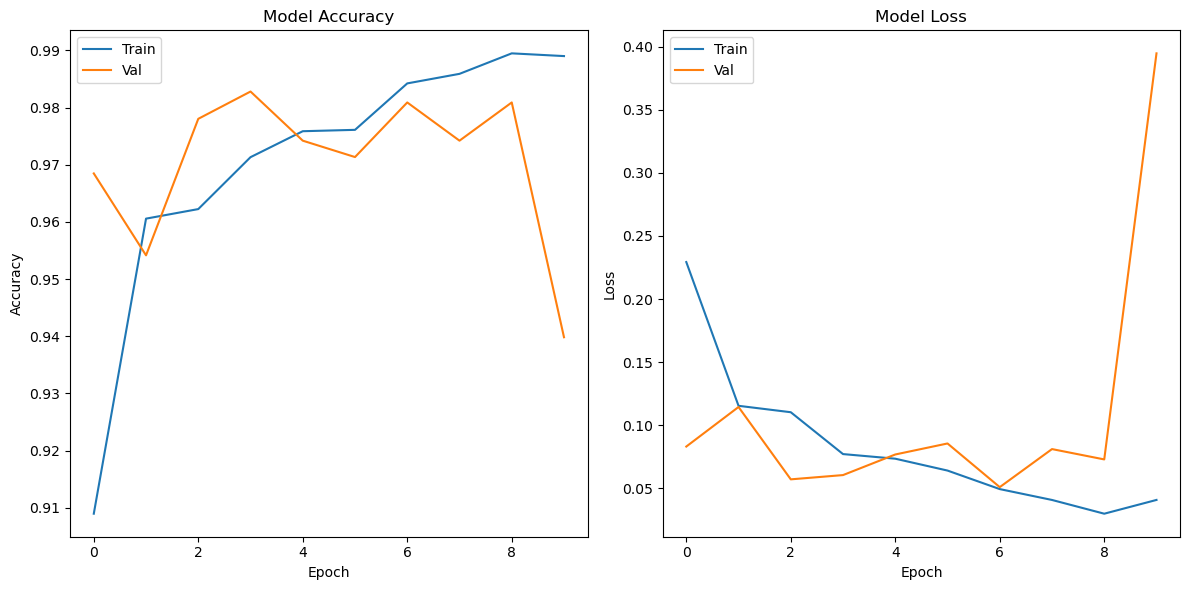

In [27]:
plot_training_history(history_mobilenet_preprocessing)

In [24]:
pred_mobilenet_preprocessing = np.argmax(model_mobilenet_preprocessing.predict(test_generator) , axis = 1)
y_test=test_generator.labels

131/131 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step


In [25]:
print(classification_report(y_test, pred_mobilenet_preprocessing))

              precision    recall  f1-score   support

           0       0.26      0.31      0.28       270
           1       0.74      0.68      0.71       777

    accuracy                           0.59      1047
   macro avg       0.50      0.50      0.50      1047
weighted avg       0.62      0.59      0.60      1047



In [28]:
confusion_matrix(y_test, pred_mobilenet_preprocessing)

array([[ 85, 185],
       [246, 531]])

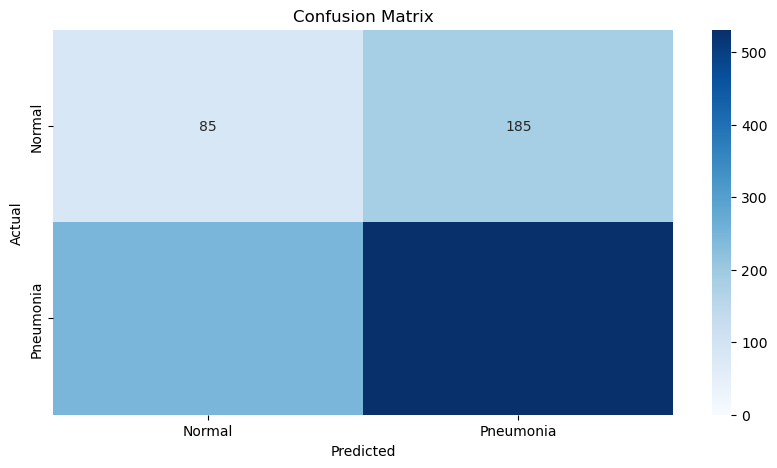

In [26]:
plot_confusion_matrix(y_test, pred_mobilenet_preprocessing)

In [29]:
# Although this model achieves good metrics during training, its performance on the validation set is poor.
# The validation accuracy is around 0.59, which is not satisfactory.

In [31]:
model_mobilenet_preprocessing_addConv2D= Sequential([
    Conv2D(32, (3,3), input_shape=image_shape, activation="relu", padding='same', strides=1),
    Conv2D(32, (3,3), activation="relu", padding='same', strides=1),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation="relu", padding='same', strides=2),
    Conv2D(64, (3,3), activation="relu", padding='same', strides=2),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), activation="relu", padding='same', strides=1),
    Conv2D(128, (3,3), activation="relu", padding='same', strides=1),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), activation="relu", padding='same', strides=1),
    Conv2D(256, (3,3), activation="relu", padding='same', strides=1),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])
model_mobilenet_preprocessing_addConv2D.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
model_mobilenet_preprocessing_addConv2D.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,288,552 (20.17 MB)

 Trainable params: 1,762,850 (6.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,525,702 (13.45 MB)

In [32]:
history_mobilenet_preprocessing_addConv2D = model_mobilenet_preprocessing_addConv2D.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 162s 307ms/step - accuracy: 0.7687 - loss: 0.4965 - val_accuracy: 0.8691 - val_loss: 0.2933
Epoch 2/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 166s 316ms/step - accuracy: 0.9250 - loss: 0.1966 - val_accuracy: 0.9398 - val_loss: 0.1518
Epoch 3/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 155s 295ms/step - accuracy: 0.9476 - loss: 0.1462 - val_accuracy: 0.9513 - val_loss: 0.1132
Epoch 4/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 155s 295ms/step - accuracy: 0.9601 - loss: 0.1131 - val_accuracy: 0.9341 - val_loss: 0.1463
Epoch 5/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 160s 305ms/step - accuracy: 0.9610 - loss: 0.1213 - val_accuracy: 0.9503 - val_loss: 0.1691
Epoch 6/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 167s 319ms/step - accuracy: 0.9667 - loss: 0.0897 - val_accuracy: 0.9713 - val_loss: 0.1205
Epoch 7/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 169s 321ms/step - accuracy: 0.9695 - loss: 0.0920 - val_accuracy: 0.9589 - val_loss: 0.1613
Epoch 8/10
524/524 ━━━━━━━━━━━━━━━━━━━━ 188s 357ms/step - accuracy: 0.9773 -

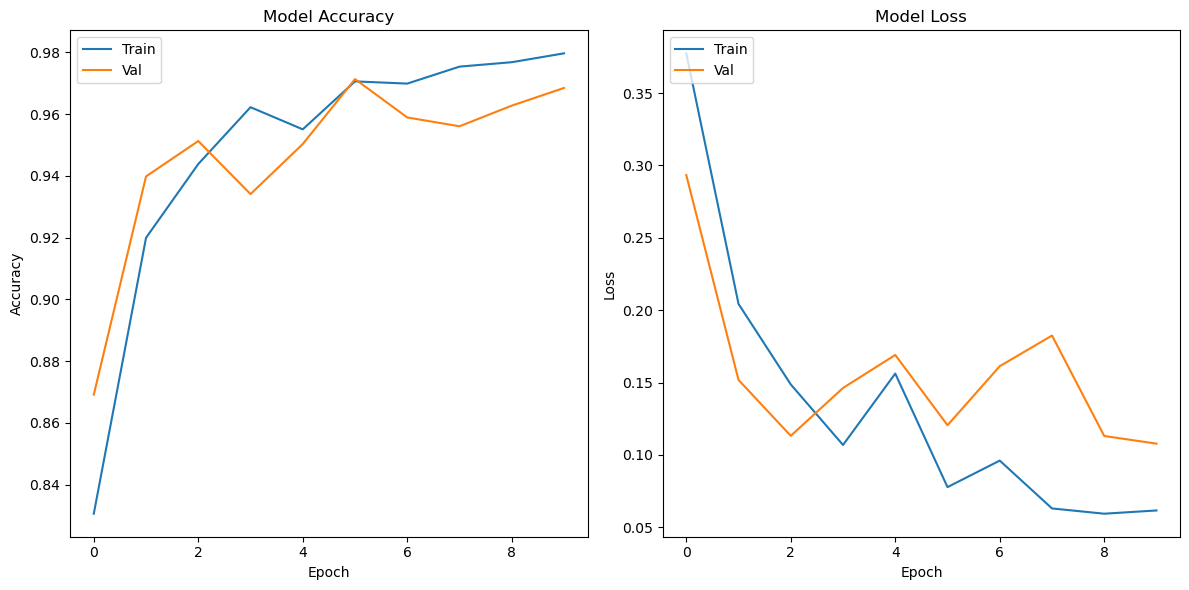

In [33]:
plot_training_history(history_mobilenet_preprocessing_addConv2D)

In [34]:
pred_mobilenet_preprocessing_addConv2D = np.argmax(model_mobilenet_preprocessing_addConv2D.predict(test_generator) , axis = 1)
y_test=test_generator.labels
print(classification_report(pred_mobilenet_preprocessing_addConv2D, y_test))

131/131 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step
              precision    recall  f1-score   support

           0       0.27      0.26      0.27       285
           1       0.73      0.74      0.74       762

    accuracy                           0.61      1047
   macro avg       0.50      0.50      0.50      1047
weighted avg       0.60      0.61      0.61      1047



In [36]:
confusion_matrix(y_test, pred_mobilenet_preprocessing_addConv2D)

array([[ 74, 196],
       [211, 566]])

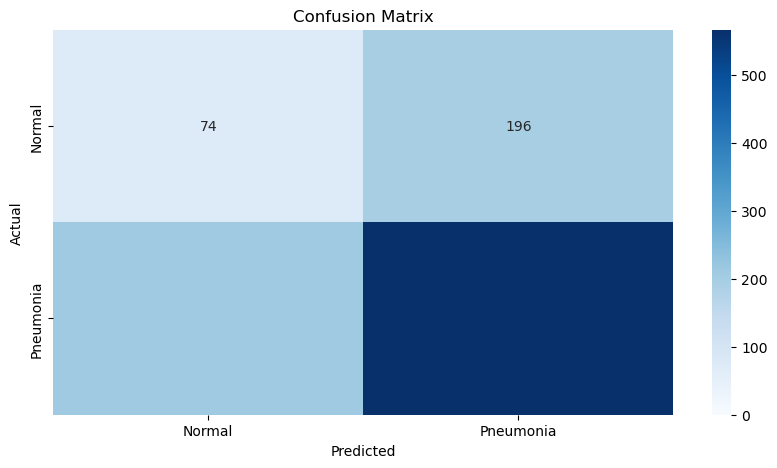

In [35]:
plot_confusion_matrix(y_test, pred_mobilenet_preprocessing_addConv2D)

We initially used ImageDataGenerator to automatically generate datasets for training deep learning models.
Initially, we applied the preprocessing_function from MobileNetV2, which normalizes image pixels to the range [-1, 1].
However, despite testing various models and configurations, we did not achieve the expected results.

The preprocessing included in MobileNetV2 is designed for specific types of data and may not be optimal for other datasets, such as our chest X-ray images. Differences in input data, such as varying contrasts, grayscale scales, and image structures, can affect the effectiveness of predefined preprocessing functions.

Since our data differed from the data for which these functions were designed, the preprocessing did not work effectively.
This forced us to manually define image processing steps tailored to the specific characteristics of our data.


## Theoretical Description of Image Preprocessing Techniques

1. **Histogram Equalization**: Histogram equalization is an image processing technique aimed at improving contrast by stretching the range of pixel intensities in the image. As a result, we obtain an image with enhanced contrast, which can facilitate analysis.

2. **Gaussian Blur**: Gaussian blur is a technique for smoothing images by applying a Gaussian filter. This filter smooths the image by averaging pixel values in the neighborhood of each pixel according to the Gaussian distribution. Gaussian blur can be useful for reducing noise in the image and smoothing edges.

3. **Bilateral Filtering**: Bilateral filtering is an advanced image processing technique that reduces noise while preserving edges in the image. It works by computing a weighted average of pixels in the vicinity of each pixel, where the weights depend on the difference in pixel values and the distance between them. Bilateral filtering is effective in removing noise while retaining important details in the image.

4. **Adaptive Masking**: This technique aims to remove unwanted elements from the image, such as background elements or disturbances that may be undesirable during analysis. In the first step, adaptive thresholding is applied, which divides the image into regions with different intensities. Then, morphological closing is applied, which helps to remove small details. Finally, based on the thresholding and closing results, a mask is created and applied to selected areas of the image.

By applying these techniques, we can improve the quality of images and prepare them for further analysis, such as machine learning. Each of these techniques has its own application and can be used depending on the specific case and analysis requirements.


### Pre-processing Methods in Chest X-ray Image Classification

**Authors:** Agata Giełczyk, Anna Marciniak, Martyna Tarczewska, Zbigniew Lutowski

This concept is derived from a scientific article.


In [38]:
def preprocess_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)

    equalized_image = cv2.equalizeHist(image)
    blurred_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)
    bilateral_filtered_image = cv2.bilateralFilter(equalized_image, 5, 75, 75)

    min_val, max_val, _, _ = cv2.minMaxLoc(image)
    threshold = (max_val + min_val) / 2
    _, binary_mask = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    masked_image = cv2.bitwise_and(image, image, mask=closed_mask)
   
    masked_image = masked_image[:, :, np.newaxis]
    
    return masked_image

In [39]:
def apply_preprocessing(df):
    processed_images = []
    for path in df['filepath']:
        processed_image = preprocess_image(path)
        processed_images.append(processed_image)
    df['processed_image'] = processed_images
    return df

In [40]:
train_df = apply_preprocessing(train_df)
test_df = apply_preprocessing(test_df)

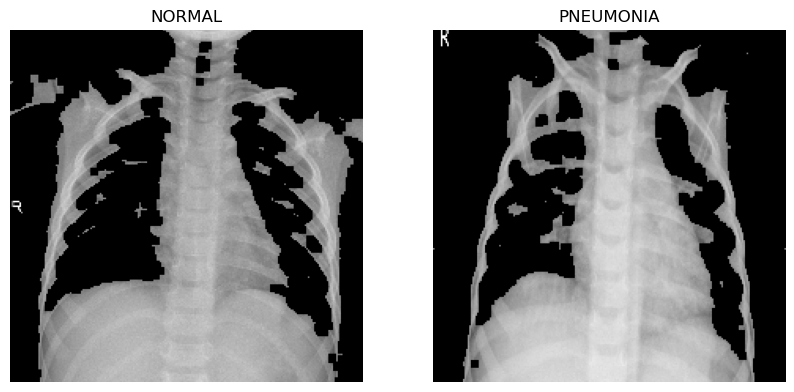

In [41]:
normal_image = train_df[train_df['label'] == 'NORMAL']['processed_image'].iloc[0]
pneumonia_image = train_df[train_df['label'] == 'PNEUMONIA']['processed_image'].iloc[0]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(normal_image, cmap='gray')
axs[0].set_title('NORMAL')
axs[0].axis('off')
axs[1].imshow(pneumonia_image, cmap='gray')
axs[1].set_title('PNEUMONIA')
axs[1].axis('off')
plt.show()

In [42]:
image_size=(224,224)
input_channels=1
image_shape=(image_size[0], image_size[1], input_channels)

In [43]:
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(train_df['label']))
y_test = to_categorical(label_encoder.transform(test_df['label']))
X_train = np.array(train_df['processed_image'].tolist())
X_test = np.array(test_df['processed_image'].tolist())

In [44]:
train_df['label'][0], y_train[0]

('NORMAL', array([0., 1.]))

In [45]:
# Creating the first model for testing after preprocessing.
# This model consists of convolutional layers followed by max pooling layers to extract features from the input images.
# The convolutional layers use ReLU activation function to introduce non-linearity to the model.
# After the convolutional layers, the feature maps are flattened and passed through fully connected layers with ReLU activation.
# Dropout layers are added to prevent overfitting by randomly dropping a fraction of input units.
# The final layer uses softmax activation function to output probabilities for each class.
# The model is compiled with the Adam optimizer and categorical crossentropy loss function, and accuracy is chosen as the evaluation metric.

model_to_test = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=image_shape),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_to_test.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
model_to_test.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,210,306 (99.98 MB)

 Trainable params: 26,210,306 (99.98 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
history_test = model_to_test.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.8245 - loss: 4.3795 - val_accuracy: 0.9370 - val_loss: 0.1627
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9295 - loss: 0.1780 - val_accuracy: 0.9570 - val_loss: 0.1138
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9589 - loss: 0.1137 - val_accuracy: 0.9542 - val_loss: 0.1242
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.9725 - loss: 0.0772 - val_accuracy: 0.9561 - val_loss: 0.1034
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9764 - loss: 0.0590 - val_accuracy: 0.9542 - val_loss: 0.1335
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - accuracy: 0.9756 - loss: 0.0749 - val_accuracy: 0.9417 - val_loss: 0.1704
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.9835 - loss: 0.0436 - val_accuracy: 0.9532 - val_loss: 0.1711
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.9925 - loss: 0.0268 - val_accu

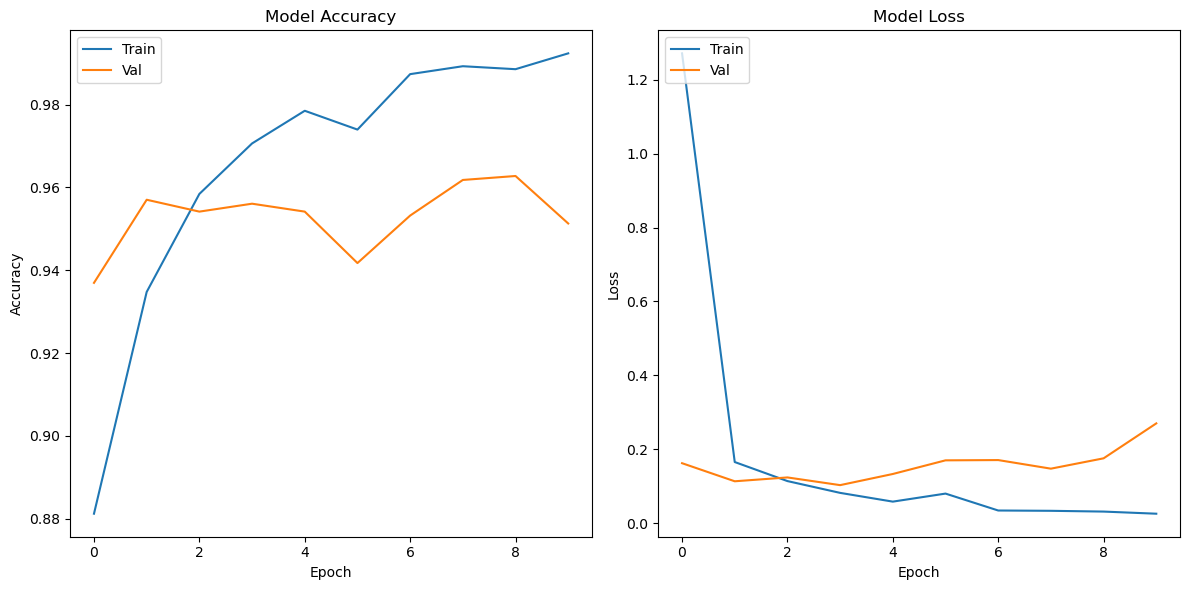

In [48]:
# We observe that the accuracy for the training set increases with the number of epochs, which is in line with our 
# expectations. Similarly, we see a decreasing trend in the loss values, indicating improvement in the model's performance.
# The plots for the validation set show slightly more variability, but still maintain accuracy within the range of 0.93 
# to 0.96, and loss below 0.2. Based on these metrics, we consider this model satisfactory.

plot_training_history(history_test)

In [49]:
test_model_accuracy = model_to_test.evaluate(X_test, y_test)[1]
print("Model Accuracy:", test_model_accuracy)

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - accuracy: 0.9463 - loss: 0.2547
Model Accuracy: 0.9512894153594971


In [50]:
test_model_pred = np.argmax(model_to_test.predict(X_test), axis=1)
y_test_binary = np.argmax(y_test, axis=1)
print(classification_report(test_model_pred, y_test_binary))

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 333ms/step
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       239
           1       0.99      0.95      0.97       808

    accuracy                           0.95      1047
   macro avg       0.92      0.95      0.93      1047
weighted avg       0.96      0.95      0.95      1047



In [51]:
confusion_matrix(y_test_binary, test_model_pred)

array([[229,  41],
       [ 10, 767]])

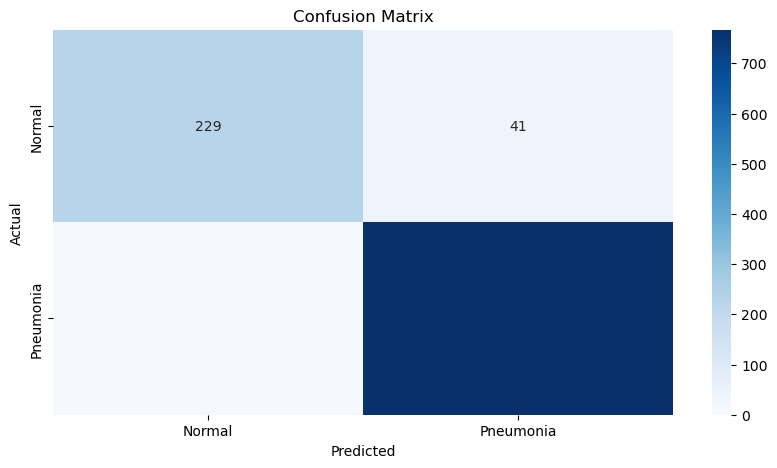

In [52]:
plot_confusion_matrix(y_test_binary, test_model_pred)

In [53]:
model_to_test.save('/Users/zuza/Desktop/model_test.h5')

In [ ]:
# With an accuracy of 95% achieved by the first model, we aim to explore more 
# complex architectures to assess the potential for further improvement.

In [60]:
model_addConv2D = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= image_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
model_addConv2D.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
model_addConv2D.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 224, 224, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,196,802 (214.37 MB)

 Trainable params: 56,196,802 (214.37 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# This model extends the previous architecture by starting with a Conv2D layer with a higher number of filters 
# and incorporating batch normalization after each convolutional layer. 

# Batch normalization is a technique used to improve the stability and performance of neural networks. 
# It normalizes the activations of each layer by adjusting and scaling the inputs, which helps in reducing 
# internal covariate shift and accelerates the training process. By normalizing the inputs to each layer, batch 
# normalization improves the convergence speed and stability of the network, making the training process more efficient 
# and less sensitive to initialization and parameter tuning.


model_with_bn = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=image_shape),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model_with_bn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
history_bn = model_with_bn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 742s 6s/step - accuracy: 0.8137 - loss: 12.3189 - val_accuracy: 0.9446 - val_loss: 0.6885
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 773s 6s/step - accuracy: 0.9134 - loss: 3.0506 - val_accuracy: 0.8243 - val_loss: 2.8533
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 770s 6s/step - accuracy: 0.9231 - loss: 1.7998 - val_accuracy: 0.9255 - val_loss: 1.3315
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3188s 24s/step - accuracy: 0.9361 - loss: 1.0072 - val_accuracy: 0.9551 - val_loss: 0.2454
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 713s 5s/step - accuracy: 0.9450 - loss: 0.6808 - val_accuracy: 0.9446 - val_loss: 0.7074
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 718s 5s/step - accuracy: 0.9547 - loss: 0.4881 - val_accuracy: 0.9561 - val_loss: 0.3116
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 703s 5s/step - accuracy: 0.9495 - loss: 0.3331 - val_accuracy: 0.9675 - val_loss: 0.1330
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 738s 6s/step - accuracy: 0.9524 - loss: 0.2822 - val_a

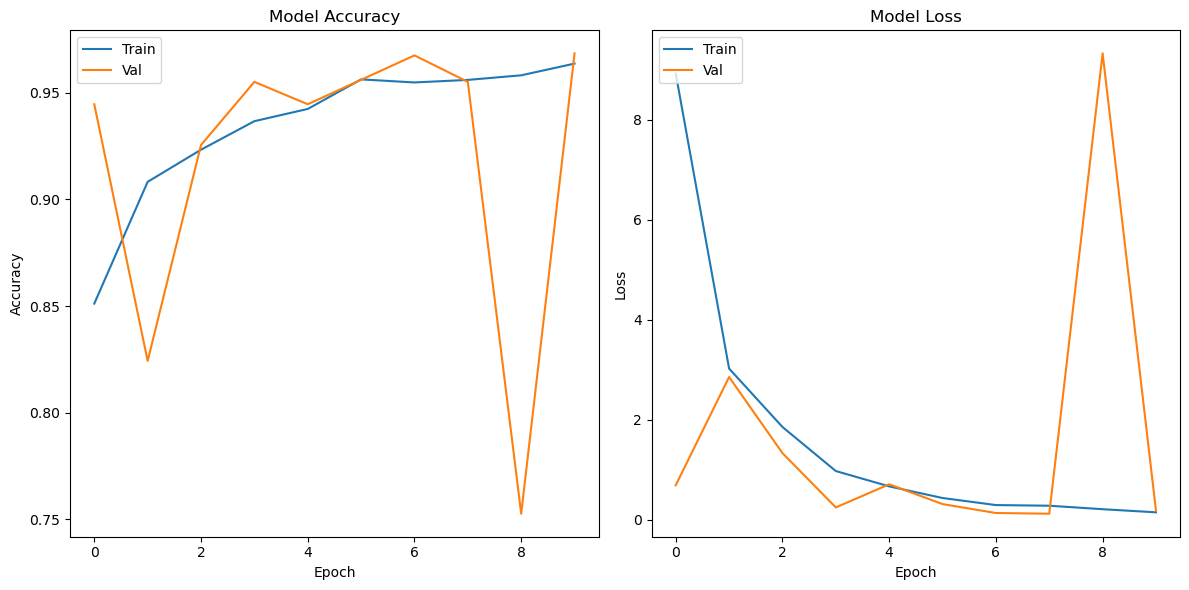

In [70]:
plot_training_history(history_bn)

In [71]:
bn_model_accuracy = model_with_bn.evaluate(X_test, y_test)[1]
print("Model Accuracy:", bn_model_accuracy)

33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9719 - loss: 0.1147
Model Accuracy: 0.9684813618659973


In [72]:
bn_model_pred = np.argmax(model_with_bn.predict(X_test), axis=1)
print(classification_report(test_model_pred, y_test_binary))

33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       239
           1       0.99      0.95      0.97       808

    accuracy                           0.95      1047
   macro avg       0.92      0.95      0.93      1047
weighted avg       0.96      0.95      0.95      1047



In [73]:
confusion_matrix(y_test_binary, bn_model_pred)

array([[245,  25],
       [  8, 769]])

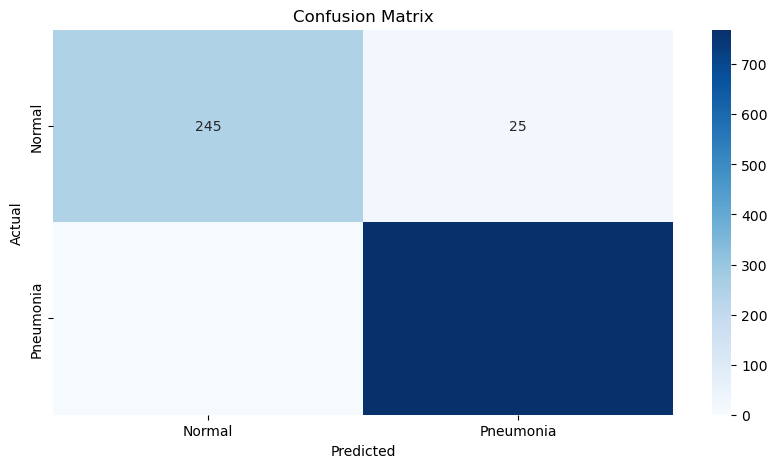

In [74]:
plot_confusion_matrix(y_test_binary, bn_model_pred)

Given these two models, we observe that they achieve similar accuracy. However, considering our business 
case – focusing on pneumonia prediction solely based on images without consulting a doctor – our primary goal is 
to minimize the number of misclassifications where pneumonia cases are wrongly predicted as normal. 

Upon analysis, we find that the second model, which incorporates batch normalization, exhibits only 8 
such misclassification. Hence, in terms of our business objectives, the second model proves to be more suitable, 
as it helps minimize the occurrence of misclassifications critical for our application.

In [75]:
model_with_bn.save('model_with_bn.h5')